In [5]:
import os
import torch
import cv2
import numpy as np


class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, images_dir, masks_dir, bbox_dir, transform=None):
       
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.bbox_dir = bbox_dir
        self.transform = transform
        self.image_files = sorted(os.listdir(images_dir))
        self.mask_files = sorted(os.listdir(masks_dir))
        self.bbox_files = sorted(os.listdir(bbox_dir))

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        
        # Get image metadata
        image_name = self.image_files[idx]
        image_path = os.path.join(self.images_dir, image_name)
        
        # Use cv2 to read image (BGR format)
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB
        
        # Get the corresponding mask file
        mask_name = image_name.replace('.jpg', '_mask.png')  # Adjust if needed
        mask_path = os.path.join(self.masks_dir, mask_name)
        
        # Use cv2 to read the mask (grayscale)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # '0' flag is for grayscale

        bbox_name = image_name.replace('.jpg', '.txt')
        bbox_path = os.path.join(self.bbox_dir, bbox_name)
        
        scale_x = 256 / 1024
        scale_y = 256 / 1024
        
        with open(bbox_path, 'r') as f:
            lines = f.readlines()
        
        for line in lines:
            coords = list(map(int, line.strip().split()))
            x1, y1, x2, y2 = coords[1:]

        bboxes = [x1, y1, x2, y2]
        
        x1 = int(x1 * scale_x)
        y1 = int(y1 * scale_y)
        x2 = int(x2 * scale_x)
        y2 = int(y2 * scale_y)
        
        #bboxes = [x1, y1, x2, y2]
        
        bboxes = torch.tensor(bboxes)
        
        
        # Apply transformations to both image and mask (if provided)
        if self.transform:
            transformed = self.transform(image=image, mask=mask)
            image = transformed["image"]
            mask = transformed["mask"]
            

        return image, mask, bboxes


In [6]:
from torchvision.transforms import Compose, ToTensor, Normalize
import cv2

# Define simplified transformations
def transform(image, mask):
    # Resize image and mask to the same size (for consistency)
    image = cv2.resize(image, (256, 256))  # Resize image to 256x256
    mask = cv2.resize(mask, (256, 256))    # Resize mask to 256x256
    
    # Convert image and mask to tensor
    image = ToTensor()(image)  # Convert image to tensor
    mask = ToTensor()(mask)    # Convert mask to tensor
    
    # Normalize the image (not the mask)
    image = Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])(image)
    

    return {"image": image, "mask": mask}


In [ ]:

images_dir = 'knee_segmentation_robo/train/new/resized_images'
masks_dir = 'knee_segmentation_robo/train/new/masks'
bbox_dir = 'knee_segmentation_robo/train/new/bbox_coords'


# Initialize dataset with transform
train_dataset = CustomDataset(images_dir, masks_dir, bbox_dir, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1, shuffle=False)

# Iterate through the DataLoader (example)
for images, masks, bboxes in train_loader:
    print(images.shape)  # Batch of images
    print(masks.shape)   # Corresponding batch of masks
    print(bboxes, bboxes.shape) 
    bbboxes = bboxes.unsqueeze(1)
    print(bbboxes, bbboxes.shape)



torch.Size([1, 3, 256, 256])
torch.Size([1, 1, 256, 256])
tensor([[135, 163, 797, 753]]) torch.Size([1, 4])
tensor([[[135, 163, 797, 753]]]) torch.Size([1, 1, 4])
torch.Size([1, 3, 256, 256])
torch.Size([1, 1, 256, 256])
tensor([[227, 271, 889, 861]]) torch.Size([1, 4])
tensor([[[227, 271, 889, 861]]]) torch.Size([1, 1, 4])
torch.Size([1, 3, 256, 256])
torch.Size([1, 1, 256, 256])
tensor([[163, 135, 753, 797]]) torch.Size([1, 4])
tensor([[[163, 135, 753, 797]]]) torch.Size([1, 1, 4])
torch.Size([1, 3, 256, 256])
torch.Size([1, 1, 256, 256])
tensor([[112, 420, 724, 994]]) torch.Size([1, 4])
tensor([[[112, 420, 724, 994]]]) torch.Size([1, 1, 4])
torch.Size([1, 3, 256, 256])
torch.Size([1, 1, 256, 256])
tensor([[ 30, 112, 604, 724]]) torch.Size([1, 4])
tensor([[[ 30, 112, 604, 724]]]) torch.Size([1, 1, 4])
torch.Size([1, 3, 256, 256])
torch.Size([1, 1, 256, 256])
tensor([[112, 420, 724, 994]]) torch.Size([1, 4])
tensor([[[112, 420, 724, 994]]]) torch.Size([1, 1, 4])
torch.Size([1, 3, 256,

In [9]:
model_type = 'vit_b'
checkpoint = 'sam_vit_b_01ec64.pth'
device = 'cuda:0'

In [10]:
from segment_anything import SamPredictor, sam_model_registry
sam_model = sam_model_registry[model_type](checkpoint=checkpoint)
sam_model.to(device)
sam_model.train()

c:\Users\ge75wix\.conda\envs\Thesis_RHS\Lib\site-packages\segment_anything\build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f)


Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-11): 12 x Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d()
    )


In [11]:
import monai

# Note: Hyperparameter tuning could improve performance here
optimizer = torch.optim.AdamW(sam_model.mask_decoder.parameters(), lr=1e-5, weight_decay=0.1)

loss_fn = monai.losses.DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')

In [30]:
from tqdm import tqdm
num_epochs = 1
epoch_losses = []

pbar = tqdm(range(num_epochs))

for epoch in pbar:
    
    train_loss = 0
    for i,data in enumerate(train_loader):

        imgs, msks, bbox = data

        imgs = imgs.to(device)

        input_image = sam_model.preprocess(imgs)
        
        msks = msks.to(device)

        input_bbox = bbox.to(device)

        # No grad here as we don't want to optimize the encoders
        with torch.no_grad():
            image_embedding = sam_model.image_encoder(input_image)

            sparse_embeddings, dense_embeddings = sam_model.prompt_encoder(
                points=None,
                boxes=input_bbox,
                masks=None,
            )

        low_res_masks, iou_predictions = sam_model.mask_decoder(
            image_embeddings=image_embedding,
            image_pe=sam_model.prompt_encoder.get_dense_pe(),
            sparse_prompt_embeddings=sparse_embeddings,
            dense_prompt_embeddings=dense_embeddings,
            multimask_output=False,
        )

        loss = loss_fn(low_res_masks,msks.float()) 
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        
    train_loss /= (i+1)
    epoch_losses.append(train_loss)
    pbar.set_description(f'Epoch {epoch + 1}/{num_epochs} | Train Loss: {train_loss:.4f}')
       


Epoch 1/1 | Train Loss: 0.0857: 100%|██████████| 1/1 [00:58<00:00, 58.60s/it]


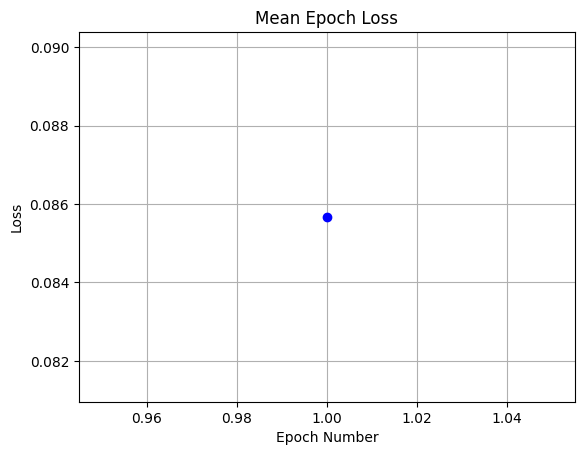

In [31]:
import matplotlib.pyplot as plt
# Plotting the loss over epochs
plt.plot(range(1, num_epochs + 1), epoch_losses, marker='o', linestyle='-', color='b')
plt.title('Mean Epoch Loss')
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

In [32]:
# Load up the model with default weights
sam_model_orig = sam_model_registry[model_type](checkpoint=checkpoint)
sam_model_orig.to(device)

Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-11): 12 x Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d()
    )


In [33]:
# Set up predictors for both tuned and original models
from segment_anything import sam_model_registry, SamPredictor
predictor_tuned = SamPredictor(sam_model)
predictor_original = SamPredictor(sam_model_orig)

In [ ]:
image = cv2.imread(f"knee_segmentation_robo/valid/new/resized_images/00162704_1x1_jpg.rf.9022cea0676f5733c375c9af58a52b4a.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

predictor_tuned.set_image(image)
predictor_original.set_image(image)

#input_bbox = np.array(bbox_coords[k][0]) 98 0 794 483
input_bbox = np.array([98, 0, 794, 483])

masks_tuned, _, _ = predictor_tuned.predict(
    point_coords=None,
    box=input_bbox,
    multimask_output=False,
)

masks_orig, _, _ = predictor_original.predict(
    point_coords=None,
    box=input_bbox,
    multimask_output=False,
)

In [35]:

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))


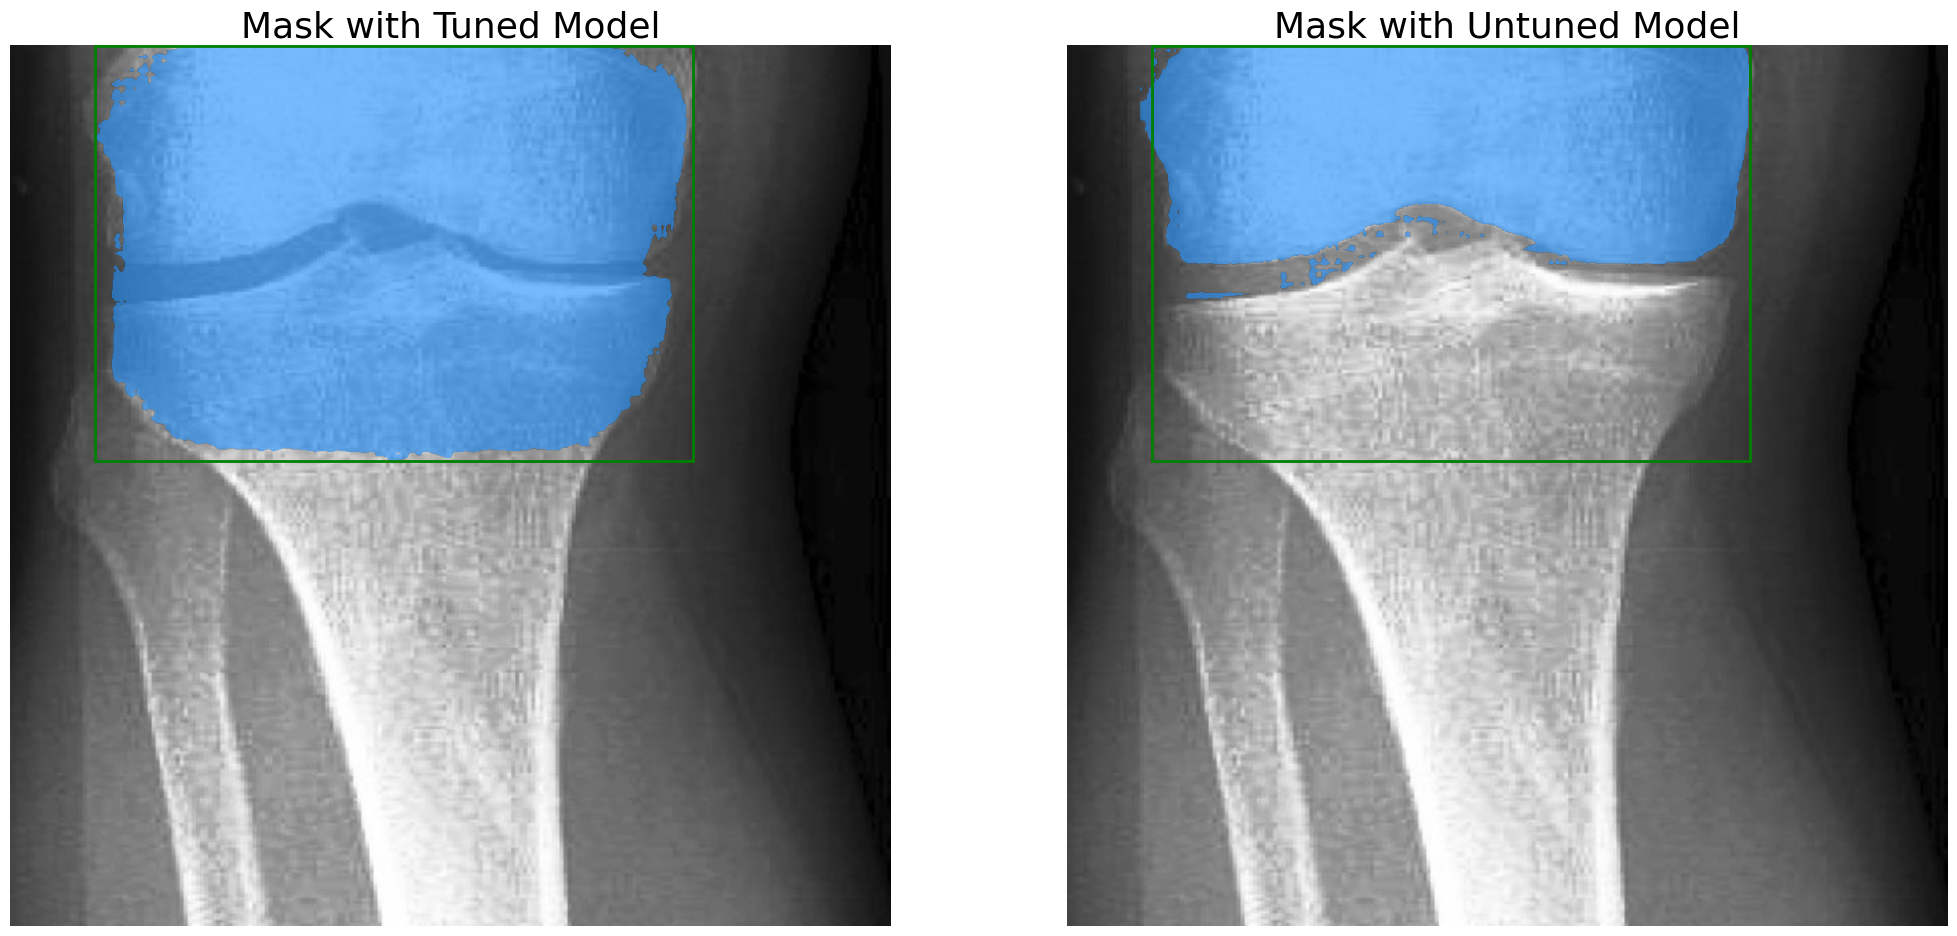

In [36]:

%matplotlib inline
_, axs = plt.subplots(1, 2, figsize=(25, 25))


axs[0].imshow(image)
show_mask(masks_tuned, axs[0])
show_box(input_bbox, axs[0])
axs[0].set_title('Mask with Tuned Model', fontsize=26)
axs[0].axis('off')


axs[1].imshow(image)
show_mask(masks_orig, axs[1])
show_box(input_bbox, axs[1])
axs[1].set_title('Mask with Untuned Model', fontsize=26)
axs[1].axis('off')

plt.show()

In [47]:
from pathlib import Path

# 1. Create models directory 
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path 
MODEL_NAME = "sam-vit-base_custom_box.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict 
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=sam_model.state_dict(), # only saving the state_dict() only saves the models learned parameters
           f=MODEL_SAVE_PATH) 

Saving model to: models\sam-vit-base_custom_box.pth
